In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob
import time

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [4]:
images_files = [f for f in glob.glob('/home/students/savemula/Intelligent_systems/data_cap/**/*', recursive= True) if not os.path.isdir(f)]
random.shuffle(images_files)

In [5]:
data = []
labels = []
for img in images_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (100,100))
    image = img_to_array(image)
    data.append(image)
    
    #labels creation
    label = img.split(os.path.sep)[-2]
    if label == 'with':
        label = 1
    else:
        label = 0
    labels.append([label]) # created a list of list of labels used for later

In [6]:
#converting into arrays
data = np.array(data)/255.0
labels = np.array(labels)

#splitting the data set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=40)

In [7]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [8]:
#augmenting the dataset as the data is very low

aug_data = ImageDataGenerator(rotation_range = 25, width_shift_range = 0.1,
                             height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [9]:
leb = to_categorical(labels, num_classes=2)
y_train[0]

array([1., 0.], dtype=float32)

## Model Creation starts here

In [10]:
try:  
    with tf.device('/device:GPU:5'):
        def build(width, height, depth, classes):
            #width is an width of image
            #depth is channels of an image
            model = Sequential()
            inputShape = (height, width, depth)
            chanDim = -1

            if K.image_data_format() == 'channels_first':
                inputShape = (depth, height, width)
                chanDim = 1

                # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
                # set axis=1 in BatchNormalization.

            model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
            model.add(Activation("relu"))
            model.add(BatchNormalization(axis=chanDim ))
            model.add(MaxPooling2D(pool_size=(3,3)))
            model.add(Dropout(0.25))

            model.add(Conv2D(64, (3,3), padding="same"))
            model.add(Activation("relu"))
            model.add(BatchNormalization(axis=chanDim))

            model.add(Conv2D(64, (3,3), padding="same"))
            model.add(Activation("relu"))
            model.add(BatchNormalization(axis=chanDim))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))

            model.add(Conv2D(128, (3,3), padding="same"))
            model.add(Activation("relu"))
            model.add(BatchNormalization(axis=chanDim))

            model.add(Conv2D(128, (3,3), padding="same"))
            model.add(Activation("relu"))
            model.add(BatchNormalization(axis=chanDim))
            model.add(MaxPooling2D(pool_size=(2,2)))
            model.add(Dropout(0.25))

            model.add(Flatten())
            model.add(Dense(1024))
            model.add(Activation("tanh"))
            model.add(BatchNormalization())
            model.add(Dropout(0.25))
            
            model.add(Dense(2048))
            model.add(Activation("tanh"))
            model.add(BatchNormalization())
            model.add(Dropout(0.25))
            
            model.add(Dense(4096))
            model.add(Activation("relu"))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))

            model.add(Dense(classes))
            model.add(Activation("sigmoid"))

            return model
except RuntimeError as e:
    print(e)

In [12]:
start = time.time()
batch_size = 1
epochs = 40
lr =1e-3
try:  
    with tf.device('/device:GPU:5'):
        model1 = build(width=100, height=100, depth=3,classes=2)
        # compile the model
        opt = RMSprop()
        model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

        # train the model
        H = model1.fit(aug_data.flow(X_train, y_train), 
                                validation_data=(X_test,y_test),
                                epochs=epochs, verbose=1)
except RuntimeError as e:
    print(e)
end = time.time()
print("time taken for execution :- {}".format(end-start))

Epoch 1/40
7/7 [==============================] - 1s 167ms/step - loss: 5.2495 - accuracy: 0.4634 - val_loss: 1.2785 - val_accuracy: 0.4804
Epoch 2/40
7/7 [==============================] - 1s 98ms/step - loss: 3.0841 - accuracy: 0.5707 - val_loss: 1.3782 - val_accuracy: 0.5196
Epoch 3/40
7/7 [==============================] - 1s 99ms/step - loss: 1.9319 - accuracy: 0.6683 - val_loss: 2.1825 - val_accuracy: 0.5196
Epoch 4/40
7/7 [==============================] - 1s 100ms/step - loss: 1.4017 - accuracy: 0.6341 - val_loss: 1.2223 - val_accuracy: 0.5196
Epoch 5/40
7/7 [==============================] - 1s 100ms/step - loss: 1.5020 - accuracy: 0.5951 - val_loss: 1.5445 - val_accuracy: 0.5196
Epoch 6/40
7/7 [==============================] - 1s 101ms/step - loss: 1.0258 - accuracy: 0.7024 - val_loss: 2.2833 - val_accuracy: 0.4804
Epoch 7/40
7/7 [==============================] - 1s 108ms/step - loss: 0.9787 - accuracy: 0.6683 - val_loss: 0.8203 - val_accuracy: 0.4706
Epoch 8/40
7/7 [======

In [143]:
model1 = build(width=100, height=100, depth=3,classes=2)
# compile the model
opt = RMSprop()
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model1.fit(aug_data.flow(X_train, y_train), 
                        validation_data=(X_test,y_test),
                        epochs=epochs, verbose=1)

ResourceExhaustedError: OOM when allocating tensor with shape[8192,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

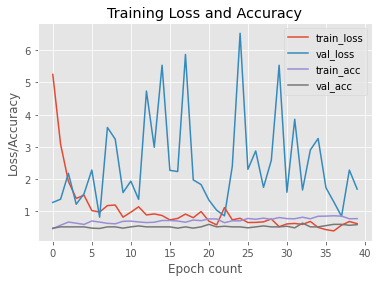

In [13]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch count")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')